# Learning from cannon trajectories: Statistical example

*Note: this example is the same as the deterministic case until you get to the inference section below.  If you ran through that example you can safely skip to that part of the notebook.*

One day for no particular reason you take your cannon and go to the park to shoot off some cannonballs.  You can control the launch angle, $\theta_0$ and the launch velocity, $v_0$ of each shot.  On top of that, the wind is blowing and your shots will be affected by wind resistance.  But, your cannon is very unsteady and wobbles constantly, randomly varying the initial velocity and angle of each shot.  Plus because the wind is randomly blowing, wind resistance is vary each time you shoot a new cannonball.

Your friend is standing (well downrange!) and can measure the trajectory of each shot -- it's vertical and horizontal distance traveled at each point in time.  Because of the random variation affecting the cannon each time you fire, each trajectory will be slightly different.  Can your friend infer the statistical distributions of the launch angle, velocity, and the wind resistance by observing enough shots?

![Can we guess from the shots?](cannon.png)

## First grab the packages we need

We'll also set a default tensor type.

In [1]:
# Setup what we need
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import scipy.stats as ss

import torch
torch.set_default_dtype(torch.float64)

from pyzag import ode, nonlinear, stochastic

import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive

## Define the model
Our model can be defined as a system of ordinary differential equations of the form
$$ \dot{v} = h - c v$$
and
$$ \dot{z} = v $$

where $v$ is a vector of two components containing the x and y velocity of the cannonball, $z$ is a vector giving the position of the ball, $h$ is a vector defining graviational acceleration, and $c$ is a constant related to the wind resistance experienced by the ball in flight.  We can expand this vector description into explicit equations for the $x$ and $y$ components of the velocity:
$$ \begin{bmatrix}
\dot{v}_x\\ 
\dot{v}_y
\end{bmatrix}

=

\begin{bmatrix}
0 \\ 
-g
\end{bmatrix}

-

c
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$
where $g$ is now the regular scalar gravitational acceleration.

We can trivially do this for the position as well:
$$ \begin{bmatrix}
\dot{z}_x\\ 
\dot{z}_y
\end{bmatrix}

=
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$

In addition, we need initial conditions for the velocities, which we can define as:
$$ \begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} =
 \begin{bmatrix}
v_0 \cos \theta_0 \\ 
v_0 \sin \theta_0
\end{bmatrix} $$
where $\theta_0$ is the cannon launch angle and $v_0$ is the scalar launch velocity.  We will let the position of the cannon, i.e. $z = 0$.

### Rate form
In pyzag we can split the definition of the model into a couple of parts.  The first is just the mathematical definition of the ODE.  We need to define this as the full system of four ODEs, two equations each for the velocity and the position.  We'll call this full system of equations $\dot{s}$ where $s$ is a vector given by
$$ s =
\begin{bmatrix}
v_x \\ 
v_y \\
z_x \\
z_y 
\end{bmatrix} $$

In addition to implementing the rate form of the equations we defined above, we also need to define the Jacobian, given by
$$
J = \frac{d \dot{s}}{d s}
$$
and return this value, along with the actual equations, as part of the `forward` operator.  The reason we need the Jacobian is explained in the next cell.

In [2]:
# Define the rate form of the model
class CannonRateForm(torch.nn.Module):
    """ODE equations defining the canon trajectories"""

    def __init__(self, c, g, theta0, v0):
        super().__init__()
        self.c = torch.nn.Parameter(c)
        self.h = torch.tensor([0, -g])
        self.theta0 = torch.nn.Parameter(theta0)
        self.v0 = torch.nn.Parameter(v0)

    def forward(self, t, s):
        """Rate form and Jacobian of the model

        Args:
            t (torch.tensor): time (not actually used in this example!)
            s (torch.tensor): concatenated velocity and position vectors
        """
        v = s[..., :2]
        # Define the rate form
        v_dot = self.h - self.c * v
        s_dot = torch.cat([v_dot, v], dim=-1)
        # Define the Jacobian
        I = torch.eye(2, device=s.device).expand(v.shape + (2,))
        zero = torch.zeros_like(I)
        Jvv = -self.c.unsqueeze(-1) * I
        Jzv = I

        J = torch.cat(
            [torch.cat([Jvv, zero], dim=-1), torch.cat([Jzv, zero], dim=-1)], dim=-2
        )

        return s_dot, J

    def y0(self, tshape):
        """Define the model initial conditions"""
        z = torch.zeros_like(self.theta0)
        y0 = (
            self.v0
            * torch.cat([torch.cos(self.theta0), torch.sin(self.theta0), z, z], dim=-1)
        ).expand(tshape + (4,))
        return y0

We will be changing these values a lot below, but let's define the model with some reasonable values for the parameters $c$, $\theta_0$, and $v_0$ and give a value for the gravitational acceleration:

In [3]:
c = torch.tensor([1.0])
g = torch.tensor(1.0)
theta0 = torch.tensor([torch.pi / 4])
v0 = torch.tensor([1.0])
rate_model = CannonRateForm(c, g, theta0, v0)

### Discrete equation
Next we need to apply a numerical time integration scheme to this ODE so that we end up with a discrete (generally) nonlinear system of equations.  We'll use the Backward Euler scheme here, which will transform the ODE into an implicit system of algebraic equations we need to solve to find the next set of velocities, as we march through the trajectory in time.  Specifically, the Backward Euler scheme will give us the equations:
$$
0 = s_{n+1} - s_n - \dot{s}_{n+1} \Delta t_{n+1}
$$
where $n+1$ means the next time step, $n$ means the previous time step, $\dot{s}_{n+1}$ means we have to evaluate the change in velocity using the velocities for the *next* step, making this an implicit equation, and $\Delta t_{n+1}$ is the change in time from step $n$ to $n+1$.  We can solve this implicit equation, for the general, nonlinear case, with Newton's method provided we know the derivative of $\dot{s}$ with respect to the state $s_{n+1}$.  This is the Jacobian we make you provide!

Luckily you don't need to do anything here as pyzag comes with predefined models for applying numerical time integration.

In [4]:
discrete_model = ode.BackwardEulerODE(rate_model)

### Solving the model
Finally we need to define an object that will actually numerically solve our discrete equations.  The inputs to this function will be the times at which we want solutions, the output will be the actual cannonball trajectories.  This is often on you, the user, to define because you might want to do some postprocessing before you pass back the series of results.  In our example the only postprocessing we'll do is to return only the cannonball trajectories and not the velocity.

To solve the discrete equations we'll use the `RecursiveNonlinearEquationSolver` class provided in the `pyzag.nonlinear` module.  This object solves for the discrete trajectories in a way that allows us to vectorize some of the time integration cost by looking to integrate `nchunk` time steps at once.  Additionally, this object takes other numerical hyperparameters related to how to numerically solve for the trajectories. The default values of these parameters are fine for this examp 

In [5]:
class Trajectory(torch.nn.Module):
    def __init__(self, discrete_equations, nchunk = 1):
        super().__init__()

        self.discrete_equations = discrete_equations
        self.solver = nonlinear.RecursiveNonlinearEquationSolver(self.discrete_equations, step_generator = nonlinear.StepGenerator(nchunk))

    def forward(self, t):
        n = len(t)

        full_trajectory = nonlinear.solve_adjoint(
            self.solver, self.discrete_equations.ode.y0(t.shape[1:-1]), n, t
        )

        return full_trajectory[...,2:]

In [6]:
nchunk = 25 # Best value will depend on your system
model = Trajectory(discrete_model, nchunk = nchunk)

## Simulating trajectories
Alright, let's simulate some trajectories.  Right now things are boring and all we can do is run a single trajectory.  But let's see what that looks like.

We have a couple more parameters to define, the time to consider and the number of time steps.

In [7]:
stop_time = 1.0
ntime = 100

Text(0, 0.5, 'y')

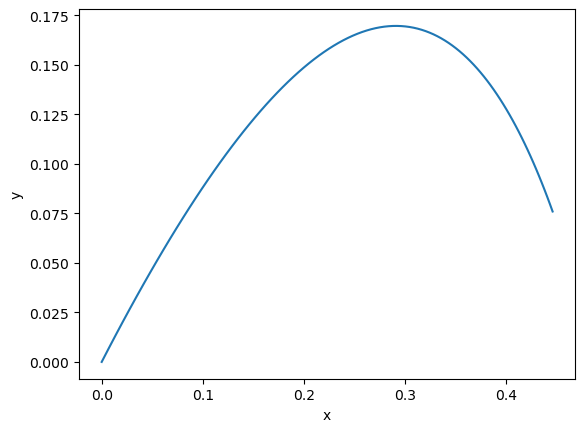

In [8]:
# The unsqueeze here are for two reasons:
# 1) We've decided that even scalar inputs need to have a shape of (1,)
# 2) Our batch shape is (1,)
# So the shape of times should be (ntime,1,1)
times = torch.linspace(0, stop_time, ntime).unsqueeze(-1).unsqueeze(-1)
# Run the model
with torch.no_grad():
    first_result = model(times)
plt.plot(first_result[:, 0, 0].detach(), first_result[:, 0, 1].detach())
plt.xlabel("x")
plt.ylabel("y")

### Simulating more trajectories

Okay, now let's generate some "data" to use in training the model.  We'll define a normal distribution for the launch angles, launch velocity, and constant "c" defining the wind resistance.  We can change the shape of the model parameters and the input times to quickly sample a whole bunch of trajectories, after first sample the parameters.

Text(0, 0.5, 'y')

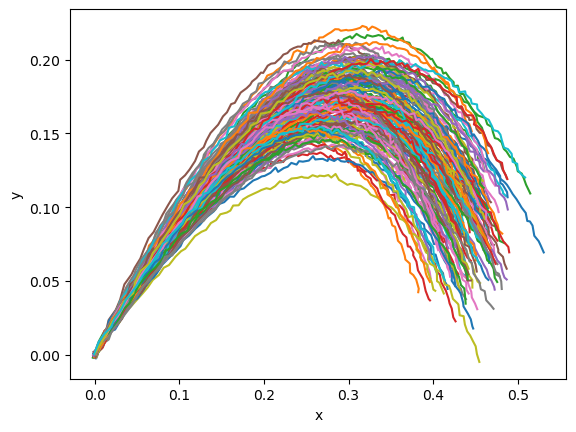

In [9]:
# Number of samples we want to generate
nsamples = 150

# Normal distribution parameters
c_loc = 1.0
c_scale = c_loc / 20.0
theta0_loc = torch.pi / 4
theta0_scale = theta0_loc / 20.0
v0_loc = 1.0
v0_scale = v0_loc / 20.0

# Actually sample the parameters
model.discrete_equations.ode.c.data = torch.normal(c_loc, c_scale, (nsamples,1))
model.discrete_equations.ode.theta0.data = torch.normal(theta0_loc, theta0_scale, (nsamples,1))
model.discrete_equations.ode.v0.data = torch.normal(v0_loc, v0_scale, (nsamples,1))

# We need times consistent with the batch size
times = torch.linspace(0, stop_time, ntime).unsqueeze(-1).unsqueeze(-1).expand((ntime, nsamples, 1))

# Go ahead and sample
with torch.no_grad():
    data_results = model(times)

# This time we'll add some noise to the observations
noise = 0.001
data_results = torch.normal(data_results, noise)

plt.plot(data_results[..., 0], data_results[..., 1])
plt.xlabel("x")
plt.ylabel("y")

## Inference

Now let's try to infer the distribution of the initial shot angle and velocity and the wind resistance just from the observed trajectorijes.  To do this we will use a Bayesian inference process called Stochastic Variational Inference and a hierachical statistical model.

The first thing to do is define the statistical model.  A hierarchical model means that the actual values of our parameters $v_0$, $\theta_0$, and $c$ will be selected randomly for each trajectory we observed (and we're simulating to compare to these observations).  But these values are not independently random, instead they are in turn sampled from higher level statistical distributions that provide values common to all the trajectories.

To make this a bit more clear, consider the values of $v_0$ used in simulating the trajectories for a single step in the inference process.  To determine what these values will be in a hierarchical model we first sample from a statistical distribution (here a normal distribution) one time to determine a mean value.  We sample from a separate distribution (here a half normal distribution) one time to determine a standard deviation.  We then sample from a (here normal) distribution with the previously sampled mean and standard deviation a number of times, with independent samples, to determine the initial velocity for each trajectory we are trying to simulate.

pyzag has wrapper objects that will take a deterministic torch model and automatically convert it to a hierarchical statistical model.  This class converts the model using mapping objects specifying how to convert each determininistic torch parameter to a distribution.  In this case we use a standard object targeting a normal distribution for the final, trajectory-specific distributions.  This inputs here is just the coefficient of variation to use to define the scale of the distributions -- the object takes the prior for the mean from the intitial value of the torch parameter.

We also need to provide a prior for the level of white noise in the data.

Again we need to reset the parameter values to be scalars.  By default these values will also determine the mean of the priors for the statistical model so we'll generate them randomly.

In [10]:
# Reset parameter values
v0_prior = torch.rand((1,)) * 2.0
theta0_prior = torch.rand((1,)) * torch.pi / 2.0
c_prior = torch.rand((1,)) * 2.0

model.discrete_equations.ode.c.data = c_prior.detach().clone()
model.discrete_equations.ode.theta0.data = theta0_prior.detach().clone()
model.discrete_equations.ode.v0.data = v0_prior.detach().clone()

cov_prior = 0.1
mapper = stochastic.MapNormal(cov_prior)
noise_prior = 0.01
hsmodel = stochastic.HierarchicalStatisticalModel(model, mapper, noise_prior)

### Guide

We also need to provide a guide -- an analytic, parameterized statistical distribution that will end up representing the true posterior distribution of the statistical model.  Luckily pyro provides built in methods for automatically creating guides.  Here we will use the `AutoDelta` distribution that will provides a maximum a posteriori (MAP) estimation for the location and scale of each parameter distribution

In [11]:
guide = pyro.infer.autoguide.guides.AutoDelta(hsmodel)

As with the deterministic case we need to provide some training hyperparameters and setup the model and the optimizer

In [12]:
lr = 5.0e-3
niter = 500
num_samples = 1

optimizer = pyro.optim.ClippedAdam({"lr": lr})
loss = Trace_ELBO(num_particles=num_samples)
svi = SVI(hsmodel, guide, optimizer, loss = loss)

And now we can run the training loop

Loss: -1.42e+05: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s]


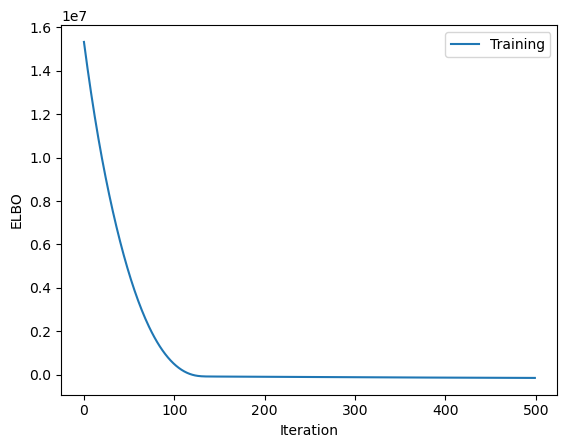

In [13]:
titer = tqdm.tqdm(range(niter))
titer.set_description("Loss:")
loss_history = []
for i in titer:
    closs = svi.step(times, results = data_results)
    loss_history.append(closs)
    titer.set_description("Loss: %3.2e" % closs)

plt.plot(loss_history, label="Training")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(loc="best")

### Let's see how well we did

By comparing the upper-level normal distributions (i.e. the distribution of the parameters overall) to the values we infered.

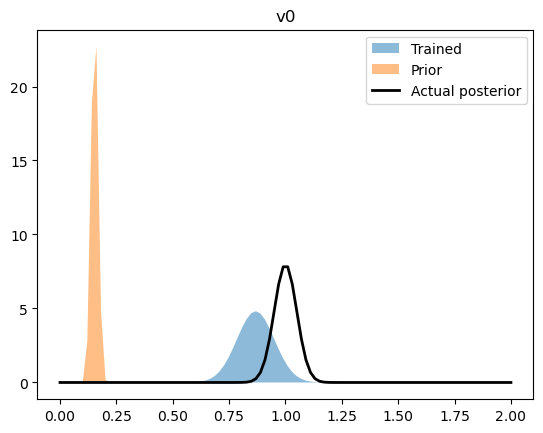

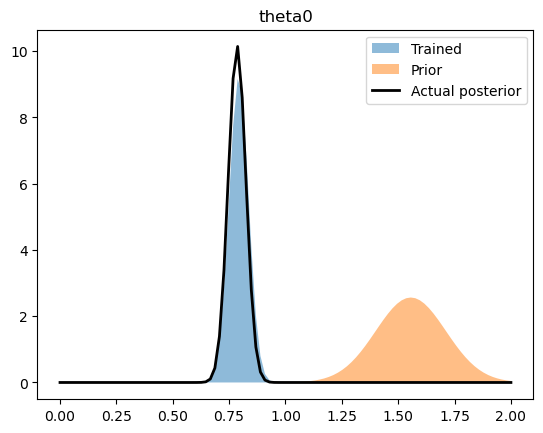

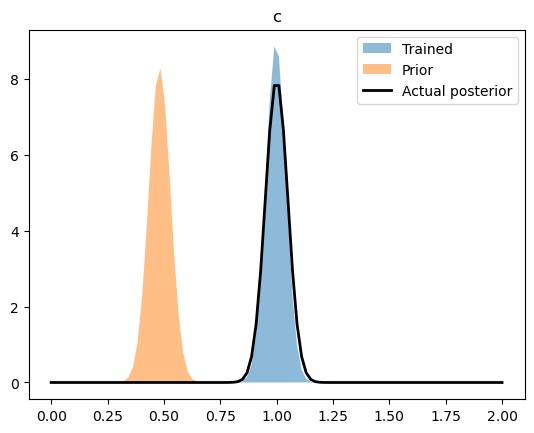

In [14]:
parameters = {
    "v0": (
        (
            "AutoDelta.discrete_equations.ode.v0_loc",
            "AutoDelta.discrete_equations.ode.v0_scale",
        ),
        (v0_prior, v0_prior * cov_prior),
        (v0_loc, v0_scale),
    ),
    "theta0": (
        (
            "AutoDelta.discrete_equations.ode.theta0_loc",
            "AutoDelta.discrete_equations.ode.theta0_scale",
        ),
        (theta0_prior, theta0_prior * cov_prior),
        (theta0_loc, theta0_scale),
    ),
    "c": (
        (
            "AutoDelta.discrete_equations.ode.c_loc",
            "AutoDelta.discrete_equations.ode.c_scale",
        ),
        (c_prior, c_prior * cov_prior),
        (c_loc, c_scale),
    ),
}

rng = np.linspace(0,2.0,100)

for name, ((train_loc, train_scale), (prior_loc, prior_scale), (act_loc, act_scale)) in parameters.items():
    train_loc = pyro.param(train_loc).data
    train_scale = pyro.param(train_scale).data

    plt.fill_between(rng, ss.norm.pdf(rng, train_loc, train_scale), label = "Trained", alpha = 0.5)
    plt.fill_between(rng, ss.norm.pdf(rng, prior_loc, prior_scale), label = "Prior", alpha = 0.5)
    plt.plot(rng, ss.norm.pdf(rng, act_loc, act_scale), label = "Actual posterior", color = 'k', lw = 2)

    plt.legend(loc='best')
    plt.title(name)

    plt.show()

We can also see how well we captured the observed trajectories by plotting a prediction interval (calculated by sampling the final, trained statistical model) versus the collection of trajectories.

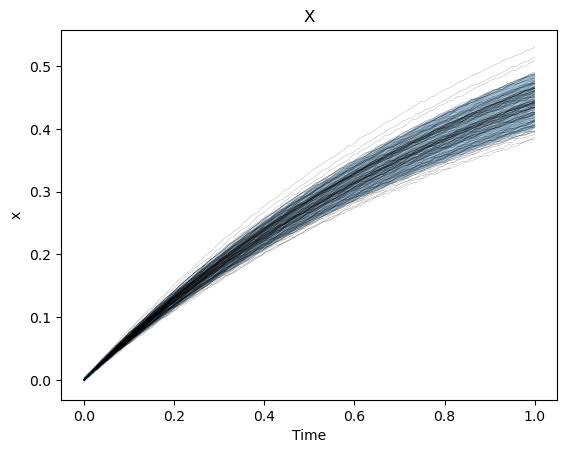

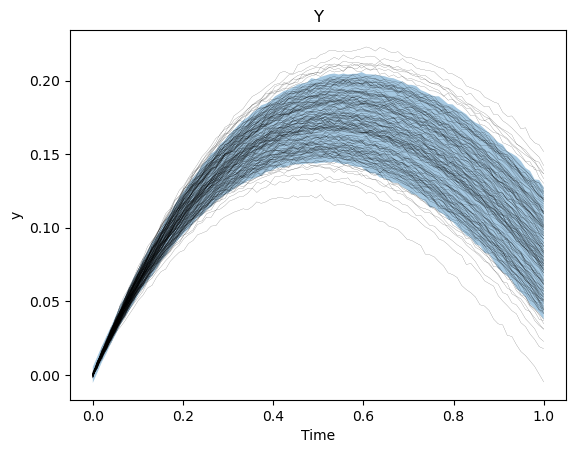

In [15]:
predict = Predictive(hsmodel, guide = guide, return_sites=("obs",), num_samples=5)
with torch.no_grad():
    samples = predict(times)["obs"]

pred = 0.05
samples = samples.transpose(0,1).reshape((ntime,-1,2))
k_lb = int(samples.shape[1]*pred)
k_ub = int(samples.shape[1]*(1-pred))

x_lb, _ = torch.kthvalue(samples[...,0], k_lb, dim = 1)
x_ub, _ = torch.kthvalue(samples[...,0], k_ub, dim = 1)

plt.figure()
plt.plot(times[...,0], data_results[..., 0], 'k-', lw = 0.1)
plt.fill_between(times[:, 0, 0], x_lb, x_ub, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("x")
plt.title("X")
plt.show()

y_lb, _ = torch.kthvalue(samples[..., 1], k_lb, dim=1)
y_ub, _ = torch.kthvalue(samples[..., 1], k_ub, dim=1)

plt.figure()
plt.plot(times[..., 0], data_results[..., 1], "k-", lw=0.1)
plt.fill_between(times[:, 0, 0], y_lb, y_ub, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Y")
plt.show()